## 📚 Prerequisites

Ensure that your Azure Services are properly set up, your Conda environment is created, and your environment variables are configured as per the instructions in the [SETTINGS.md](SETTINGS.md) file.

The PDFs used during this case study are publicly available:

- [Fisher EWD/EWS/EWT Valves through NPS 12x8 Instruction Manual](https://www.emerson.com/documents/automation/instruction-manual-fisher-ewd-ews-ewt-valves-through-nps-12x8-en-124788.pdf)
- [Fieldvue DVC6200 HW2 Digital Valve Controller Instruction Manual](https://www.emerson.com/documents/automation/instruction-manual-fieldvue-dvc6200-hw2-digital-valve-controller-en-123052.pdf)

These documents were chosen due to their complexity, particularly in terms of tables and interpretation of graphs. To follow along with this notebook, please download these files and upload them to your blob storage container.

## 📋 Table of Contents

This notebook guides you through the following sections:

1. **Convert PDF Documents into Images using `OCRHelper`**: This helper manages the connection to an Azure Blob Storage container and assists in converting PDF files into images, which can later be consumed by the OCR GPT-4 Vision model.

2. **Using GPT4 Vision for OCR**: After initializing the `GPT4VisionManager`, we use it to perform Optical Character Recognition (OCR) on an image. The GPT-4 Vision model is capable of recognizing and extracting text from images, which can be useful in a variety of applications such as document analysis, data extraction, and more.

3. **Utilizing AzureOpenAIManager for Contextual Text Generation in a RAG Pattern Simulation**: In this section, we simulate a Retrieval-Augmented Generation (RAG) pattern. Here, a user poses a question (query), and our application, using the Large Language Model (LLM), fetches information based on similarity. This similarity is extracted from the GPT-4 Vision model and stored in our vector database. We utilize the `AzureOpenAIManager` class to process the output from the OCR step. This class is specifically designed to interact with the Azure OpenAI API and generate responses based on given prompts and conversation history. We employ these methods to generate meaningful and context-aware responses based on the text extracted from the images in the OCR step. This approach enables us to create a more interactive and intelligent system that can understand and respond to the content of the images.


In [2]:
import os

# Define the target directory
target_directory = r"C:\Users\pablosal\Desktop\gbbai-azure-ai-document-intelligence"  # change your directory here

# Check if the directory exists
if os.path.exists(target_directory):
    # Change the current working directory
    os.chdir(target_directory)
    print(f"Directory changed to {os.getcwd()}")
else:
    print(f"Directory {target_directory} does not exist.")

Directory changed to C:\Users\pablosal\Desktop\gbbai-azure-ai-document-intelligence


## Convert PDF Documents into Images using `OCRHelper`

This section of code is using the `OCRHelper` class from the `ocr_data_extractor` module to extract images from a PDF file stored in an Azure Blob Storage container.

Here's a step-by-step explanation:

1. `ocr_data_extractor_helper = OCRHelper(container_name="ocrtest")`: This line initializes an instance of the `OCRHelper` class, which is designed to interact with a specific Azure Blob Storage container. In this case, the container is named "ocrtest".

2. `INPUT_PATH` and `OUTPUT_PATH` are defined. `INPUT_PATH` is the URL of the PDF file in the Azure Blob Storage container, and `OUTPUT_PATH` is the local directory where the extracted images will be saved.

3. `ocr_data_extractor_helper.extract_images_from_pdf(input_path=INPUT_PATH, output_path=OUTPUT_PATH)`: This line calls the `extract_images_from_pdf` method of the `OCRHelper` instance. This method downloads the PDF file from the `INPUT_PATH`, converts each page of the PDF into an image, and saves the images to the `OUTPUT_PATH`.

In [3]:
from src.extractors.ocr_data_extractor import OCRHelper

ocr_data_extractor_helper = OCRHelper(container_name="ocrtest")

In [ ]:
# Replace with the URL of your PDF file in Azure Blob Storage
INPUT_PATH = "https://testeastusdev001.blob.core.windows.net/ocrtest/"

# Replace with the path to your local directory where the images will be saved
OUTPUT_PATH = "C:\\Users\\pablosal\\Desktop\\gbbai-azure-ai-document-intelligence\\notebooks\\dev\\images"

ocr_data_extractor_helper.extract_images_from_pdf(
    input_path=INPUT_PATH, output_path=OUTPUT_PATH
)

## Using GPT4 Vision for OCR

In this section, we initialize the `GPT4VisionManager` and use it to perform Optical Character Recognition (OCR) on an image. The `GPT4VisionManager` is a class from the `src.ocr.transformer` module that manages the interaction with the GPT-4 Vision model.

The `call_gpt4v_image` method of the `GPT4VisionManager` is used to perform OCR on the image at `image_file_path`. This method takes several parameters:

- `image_file_path`: The path to the image file.
- `system_instruction`: A high-level instruction that sets the role of the AI.
- `user_instruction`: A specific instruction that tells the AI what to do.
- `ocr`: If set to `True`, OCR is enabled.
- `use_vision_api`: If set to `True`, the Vision API is used.
- `display_image`: If set to `True`, the image is displayed.
- `max_tokens`: Limits the number of tokens in the output.
- `seed`: Sets the seed for reproducibility.

The `system_instruction` and `user_instruction` parameters are used to guide the AI model's behavior. They are essentially the instructions that you give to the AI model.

`system_instruction` is a high-level instruction that sets the role of the AI. In your case, `sys_message` is set to "You are an AI assistant capable of processing and summarizing complex documents with diagrams and tables." This instructs the AI to act as an assistant that can process and summarize complex documents.

`user_instruction` is a more specific instruction that tells the AI what to do. In your case, `user_prompt` is a detailed instruction asking the AI to analyze a document, provide a summary, and then extract key information and details from tables and diagrams in the form of bullet points.

Depending on the task, you can change these instructions. For example, if you want the AI to extract only the key points from a document without providing a summary, you can set `user_instruction` to "Please extract the key points from this document." If you want the AI to act as a translator, you can set `system_instruction` to "You are an AI assistant capable of translating text from English to French."

Remember, the instructions should be clear and specific to guide the AI to perform the desired task effectively.

In [5]:
from src.ocr.transformer import GPT4VisionManager

gpt_vision_client = GPT4VisionManager()

In [6]:
sys_message = "You are an AI assistant capable of processing and summarizing complex documents with diagrams and tables."
user_prompt = """
Please analyze this document and provide the information in the following format:

1. Summary: Provide a concise summary of the document, focusing on the main points and overall context.

2. Content: Your task is to extract all information from the document in a detailed and granular manner. Pay special attention to tables and diagrams. Ensure that no information is omitted. Avoid summarizing; instead, be explicit with all the details and cells. Take your time, as the purpose is to thoroughly record all the information from the document.

3. Category: List key categories or keywords, with a focus on main products or concepts mentioned in the document. Categories should be abstracted and listed, separated by commas, with a maximum of 10 words.

The purpose is to enable another system to read and understand this information in detail, to facilitate answering precise questions based on the document's context.

Please return the information in the following format:

#summary
<summary text>

#content
<content text>

#category
[<category 1>, <category 2>, <category 3>, ...]
"""

### Ground truth

In this section, we're using the GPT-4 Vision model to perform Optical Character Recognition (OCR) on two specific images. These images serve as test cases to evaluate the effectiveness of our OCR process.

In [7]:
image_file_paths = [
    "https://testeastusdev001.blob.core.windows.net/ocrimages/instruction-manual-fieldvue-dvc6200-hw2-digital-valve-controller-en-123052-page-33.png",
    "C:\\Users\\pablosal\\Desktop\\gbbai-azure-ai-document-intelligence\\notebooks\\dev\\images\\instruction-manual-fisher-ewd-ews-ewt-valves-through-nps-12x8-en-124788-page-14.png",
    "C:\\Users\\pablosal\\Desktop\\gbbai-azure-ai-document-intelligence\\utils\\images\\double_arrangements.png",
]

In [ ]:
ocr_recognizer_1 = gpt_vision_client.call_gpt4v_image(
    image_file_paths[0],
    system_instruction=sys_message,
    user_instruction=user_prompt,
    ocr=True,
    use_vision_api=True,
    display_image=True,
    max_tokens=2000,
    seed=42,
)
print(ocr_recognizer_1)

2024-01-08 10:15:53,901 - micro - MainProcess - INFO     Preparing instruction for GPT-4 Vision API call. (transformer.py:prepare_instruction:125)
2024-01-08 10:15:53,902 - micro - MainProcess - INFO     Instruction: [{'role': 'system', 'content': [{'type': 'text', 'text': 'You are an AI assistant capable of processing and summarizing complex documents with diagrams and tables.'}]}, {'role': 'user', 'content': [{'type': 'text', 'text': "\nPlease analyze this document and provide the information in the following format:\n\n1. Summary: Provide a concise summary of the document, focusing on the main points and overall context.\n\n2. Content: Your task is to extract all information from the document in a detailed and granular manner. Pay special attention to tables and diagrams. Ensure that no information is omitted. Avoid summarizing; instead, be explicit with all the details and cells. Take your time, as the purpose is to thoroughly record all the information from the document.\n\n3. Cat

2024-01-08 10:17:00,509 - micro - MainProcess - INFO     Request successful. (transformer.py:call_gpt4v_image:279)


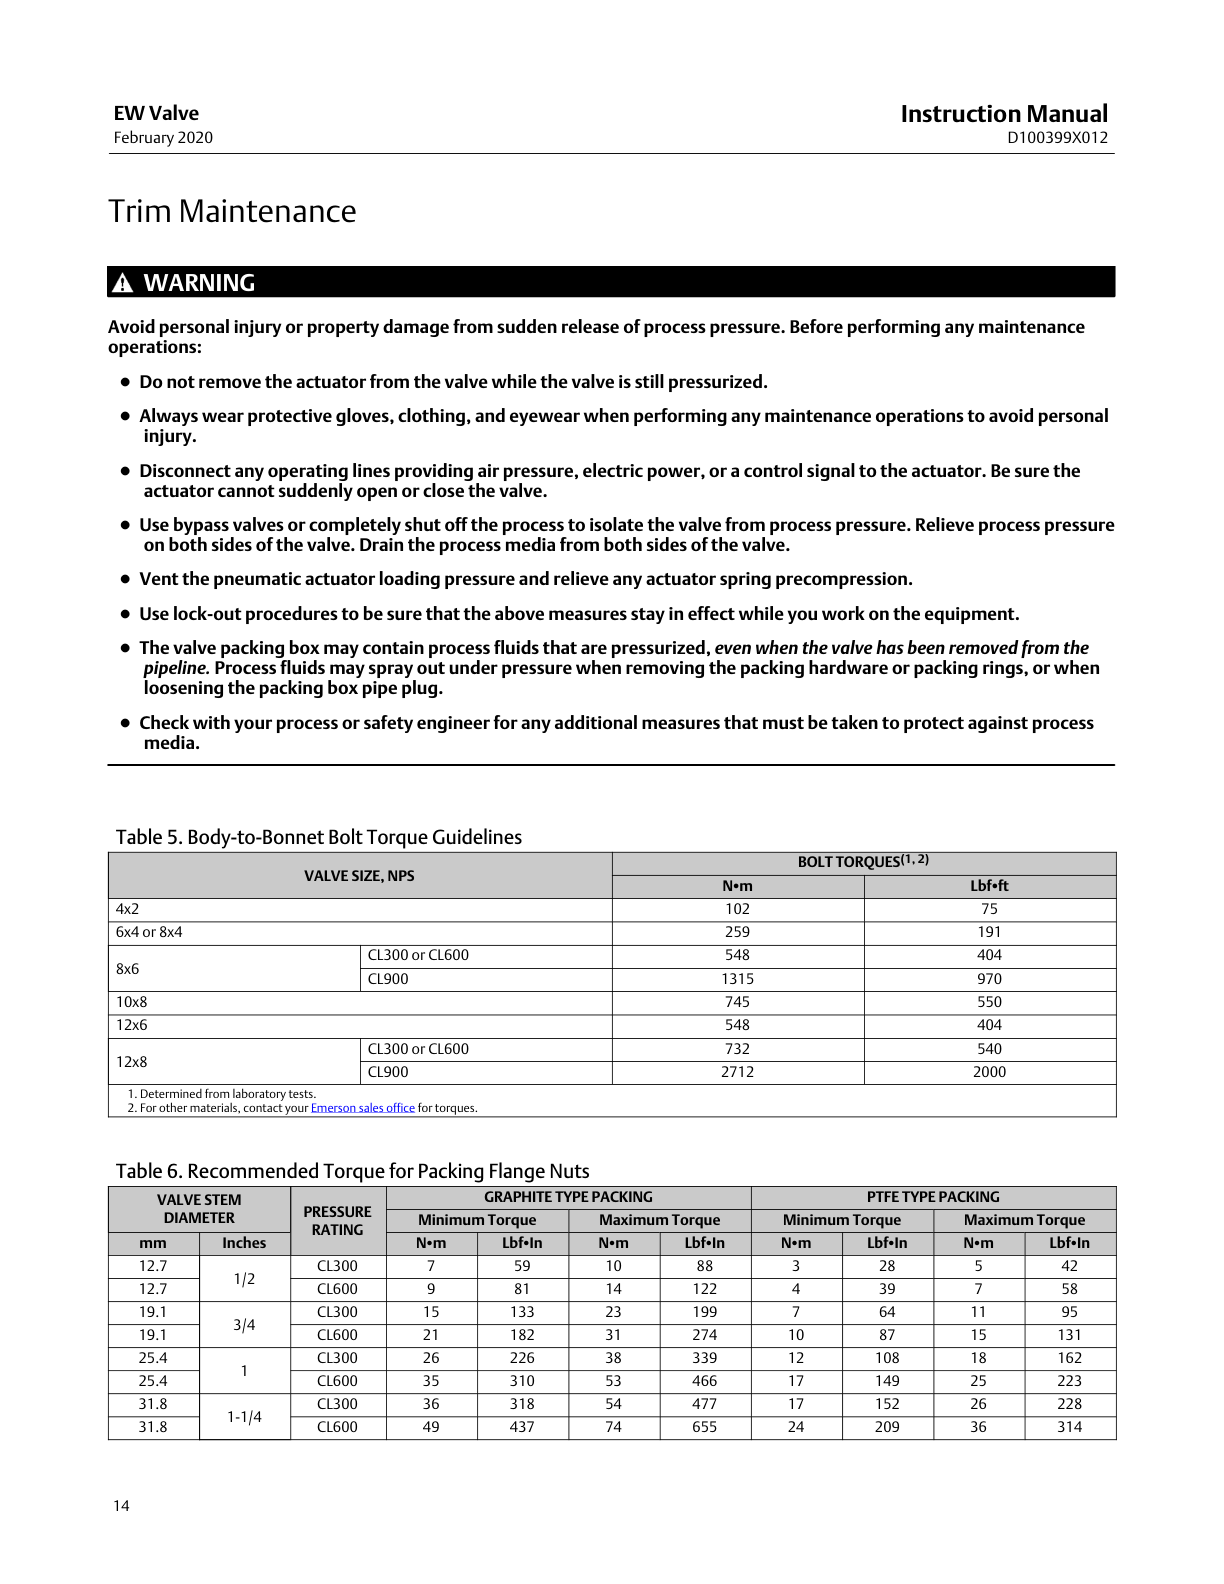

#summary
The document is an instruction manual for EW Valve, specifically focusing on trim maintenance procedures to avoid injury or property damage due to the sudden release of process pressure. It outlines safety precautions to take before maintenance, such as depressurizing the valve, wearing protective gear, and implementing lock-out procedures. Additionally, it provides detailed torque guidelines for body-to-bonnet bolts and packing flange nuts for various valve sizes and pressure ratings, including both graphite and PTFE type packing.

#content
- The document is an instruction manual from EW Valve, dated February 2020, with the reference number D100399X012.
- The section is dedicated to Trim Maintenance and starts with a warning about avoiding personal injury or property damage from the sudden release of process pressure.
- Safety precautions before maintenance include:
  - Not removing the actuator from the valve if it's pressurized.
  - Wearing protective gloves, clothing, and 

In [24]:
ocr_recognizer_2 = gpt_vision_client.call_gpt4v_image(
    image_file_paths[1],
    system_instruction=sys_message,
    user_instruction=user_prompt,
    ocr=True,
    use_vision_api=True,
    display_image=True,
    max_tokens=2000,
    seed=42,
)
print(ocr_recognizer_2)

2024-01-18 11:36:31,046 - micro - MainProcess - INFO     Preparing instruction for GPT-4 Vision API call. (transformer.py:prepare_instruction:119)
2024-01-18 11:36:31,048 - micro - MainProcess - INFO     Instruction: [{'role': 'system', 'content': [{'type': 'text', 'text': 'You are an AI assistant capable of processing and summarizing complex documents with diagrams and tables.'}]}, {'role': 'user', 'content': [{'type': 'text', 'text': "\nPlease analyze this document and provide the information in the following format:\n\n1. Summary: Provide a concise summary of the document, focusing on the main points and overall context.\n\n2. Content: Your task is to extract all information from the document in a detailed and granular manner. Pay special attention to tables and diagrams. Ensure that no information is omitted. Avoid summarizing; instead, be explicit with all the details and cells. Take your time, as the purpose is to thoroughly record all the information from the document.\n\n3. Cat

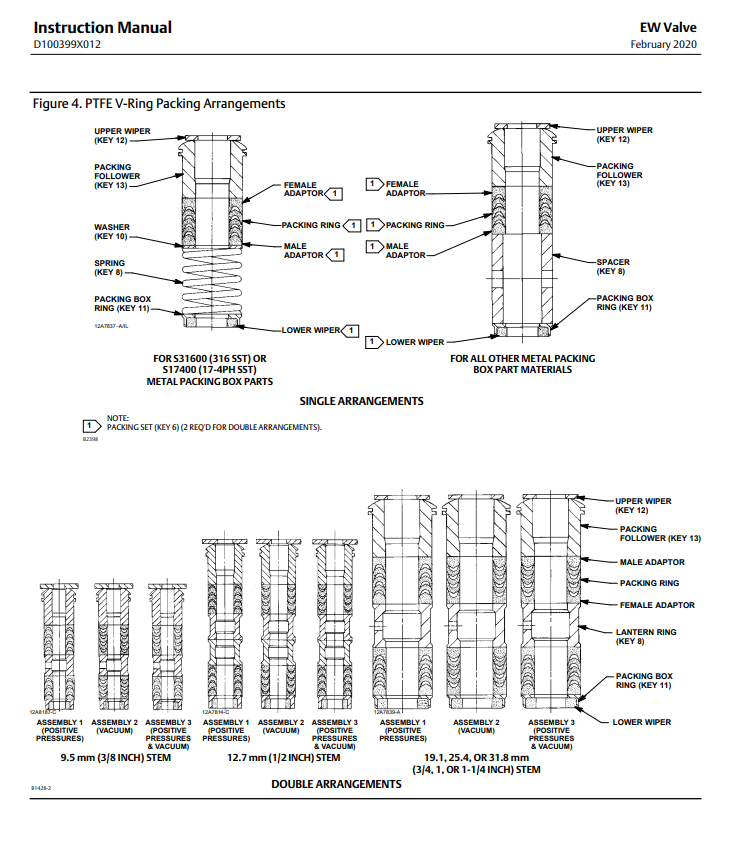

#summary
The document is an instruction manual for EW Valve, specifically detailing the PTFE V-Ring Packing Arrangements. It includes diagrams showing the configuration of components for single and double arrangements based on various stem sizes and pressure conditions. The manual identifies each part by a key number and notes the requirement for a packing set for double arrangements.

#content
- The document title is "Instruction Manual" for the "EW Valve," with a reference number "D100399X012," dated February 2020.
- Figure 4 illustrates the "PTFE V-Ring Packing Arrangements."
- The diagram shows the following components for a single arrangement:
  - Upper Wiper (Key 12)
  - Packing Follower (Key 13)
  - Female Adaptor
  - Packing Ring
  - Male Adaptor
  - Washer (Key 10)
  - Spring (Key 8)
  - Packing Box Ring (Key 11)
  - Lower Wiper
- There is a note indicating that the Packing Set (Key 6) is required for double arrangements.
- The diagram also includes specific arrangements for d

In [10]:
ocr_recognizer_3 = gpt_vision_client.call_gpt4v_image(
    image_file_paths[2],
    system_instruction=sys_message,
    user_instruction=user_prompt,
    ocr=True,
    use_vision_api=True,
    display_image=True,
    max_tokens=2000,
    seed=42,
)
print(ocr_recognizer_3)

## Utilizing AzureOpenAIManager for Contextual Text Generation in a RAG Pattern Simulation

In this section, we simulate a RAG pattern where a user poses a question (query) and our application, LLM, fetches information based on similarity extracted from the GPT-4 Vision model, which is stored in our vector database.

We will be using the `AzureOpenAIManager` class to process the output from the OCR step. This class is designed to interact with the Azure OpenAI API and generate responses based on given prompts and conversation history.

The `AzureOpenAIManager` class has two main methods: `generate_text_completion` and `generate_text_with_contextual_history`. The first method, `generate_text_completion`, generates a text completion based on a given prompt. The second method, `generate_text_with_contextual_history`, generates a text response considering the conversation history as context and focusing on the latest prompt.

We will use these methods to generate meaningful and context-aware responses based on the text extracted from the images in the OCR step. This will allow us to create a more interactive and intelligent system that can understand and respond to the content of the images.

In [12]:
from src.aoai.azure_openai import AzureOpenAIManager

azure_openai_client = AzureOpenAIManager()

#### Initial Interaction Between User and LLM Application

In [14]:
conversation_history = []
system_message = "You are an AI assistant expert engineer, capable of supporting engineers in the field with clear and precise instructions based on context."
user_query = """Could you provide details on Single Arrangements for S31600 (316 SST) or S17400 (17-4PH SST) metal packing box parts?"""
user_prompt_1 = f"""Given the context: {ocr_recognizer_3}, please answer the following question: {user_query}. 
Please limit your response to the information provided in the context. If there isn't enough information, state that more is needed. To personalize your response, include emoticons."""

In [18]:
response_1 = azure_openai_client.generate_chat_response(
    conversation_history=conversation_history,
    system_message_content=system_message,
    query=user_prompt_1,
    max_tokens=1000,
    temperature=0.7,
    seed=42,
)

2024-01-18 11:41:04,957 - micro - MainProcess - INFO     Sending request to OpenAI with query: Given the context: #summary
The document is an instruction manual for EW Valve, specifically detailing the PTFE V-Ring Packing Arrangements. It includes diagrams showing the configuration of components for single and double arrangements based on various stem sizes and pressure conditions. The manual identifies each part by a key number and notes the requirement for a packing set for double arrangements.

#content
- The document title is "Instruction Manual" for the "EW Valve," with a reference number "D100399X012," dated February 2020.
- Figure 4 illustrates the "PTFE V-Ring Packing Arrangements."
- The diagram shows the following components for a single arrangement:
  - Upper Wiper (Key 12)
  - Packing Follower (Key 13)
  - Female Adaptor
  - Packing Ring
  - Male Adaptor
  - Washer (Key 10)
  - Spring (Key 8)
  - Packing Box Ring (Key 11)
  - Lower Wiper
- There is a note indicating that th

2024-01-18 11:42:14,150 - micro - MainProcess - INFO     Received response from OpenAI: Certainly! Based on the information provided in the context, here are the details for a Single Arrangement using S31600 (316 SST) or S17400 (17-4PH SST) metal packing box parts for the EW Valve:

- You will start with the Upper Wiper (Key 12), which serves as the initial barrier to external contaminants.
- Following the Upper Wiper, install the Packing Follower (Key 13) to compress and retain the packing set.
- Proceed with the installation of the Female Adaptor, which likely interfaces with the packing follower.
- Next, place the Packing Ring, which provides the actual seal around the valve stem.
- Below the Packing Ring, insert the Male Adaptor, which may act as a counterpart to the female adaptor.
- Make sure to include a Washer (Key 10) to distribute the load and prevent damage to the components below it.
- Install the Spring (Key 8), which applies consistent pressure to maintain the integrity o

In [19]:
print(response_1)

Certainly! Based on the information provided in the context, here are the details for a Single Arrangement using S31600 (316 SST) or S17400 (17-4PH SST) metal packing box parts for the EW Valve:

- You will start with the Upper Wiper (Key 12), which serves as the initial barrier to external contaminants.
- Following the Upper Wiper, install the Packing Follower (Key 13) to compress and retain the packing set.
- Proceed with the installation of the Female Adaptor, which likely interfaces with the packing follower.
- Next, place the Packing Ring, which provides the actual seal around the valve stem.
- Below the Packing Ring, insert the Male Adaptor, which may act as a counterpart to the female adaptor.
- Make sure to include a Washer (Key 10) to distribute the load and prevent damage to the components below it.
- Install the Spring (Key 8), which applies consistent pressure to maintain the integrity of the seal.
- Finally, secure the assembly with the Packing Box Ring (Key 11) at the bot

#### 2 Interaction Between User and LLM Application

In [26]:
conversation_history = []
system_message = "You are an AI assistant expert engineer, capable of supporting engineers in the field with clear and precise instructions based on context."
query_1 = """What is the outgoing partial stroke pressure limit for an actuator style spring and diaphragm relay type B under open zero power condition?"""
user_prompt_1 = f"""Given the context: {ocr_recognizer_1}, please answer the following question: {query_1}. 
Please limit your response to the information provided in the context. If there isn't enough information, state that more is needed. To personalize your response, include emoticons."""

In [27]:
response_1 = azure_openai_client.generate_chat_response(
    conversation_history=conversation_history,
    system_message_content=system_message,
    latest_prompt=user_prompt_1,
    max_tokens=1000,
    temperature=0.7,
    seed=42,
)

2024-01-08 10:17:00,645 - micro - MainProcess - INFO     Sending request to OpenAI with prompt: Given the context: #summary
The document is an instruction manual from December 2022 detailing the configuration of the pressure signal for different relay types and the procedure for manually setting the Outgoing Pressure Threshold using ValveLink software. It includes a guide through the process of connecting the DVC6200, disabling and enabling the Outgoing Pressure Limit, running a partial stroke test, and using the Press/Time radio button to find the minimum or maximum actuator pressure. The document also features Table 3-7 which provides estimates for Outgoing Partial Stroke Pressure Limits for different actuator styles and relay types, taking into account the zero power condition, PST starting point, and partial stroke pressure limit.

#content
- The document provides instructions on setting the partial stroke Outgoing Pressure Threshold with ValveLink software.
- Relay types A or C us

In [28]:
print(response_1)

For a Spring and Diaphragm actuator with relay type B under an Open Zero Power Condition with the PST Starting Point Open, the outgoing partial stroke pressure limit is calculated as:

Pmax + 0.25 * (Bench Set High - Bench Set Low)

This calculation is based on the information provided in Table 3-7 of the instruction manual. 😊

Remember to obtain the correct values for Pmax (maximum actuator pressure), Bench Set High, and Bench Set Low from your system to perform the calculation accurately.


#### Second Interaction Between User and LLM Application

In this step, we pass the system's response from the first interaction to provide context. This context, grounded in data extracted from the GPT-4 Vision model, enables the LLM application to "reason" with the correct information and provide the most "appropriate" answer.

In [29]:
conversation_history = [
    {"role": "user", "content": query_1},
    {"role": "system", "content": response_1},
]
query_2 = """PST starting point is Open"""
user_prompt = f"""Given the context: {ocr_recognizer_1}, please answer the following question: {query_2}. 
Please limit your response to the information provided in the context. If there isn't enough information, state that more is needed. To personalize your response, include emoticons."""

In [30]:
response_2 = azure_openai_client.generate_chat_response(
    conversation_history=[],
    system_message_content=system_message,
    latest_prompt=user_prompt,
    max_tokens=1000,
    temperature=0.7,
    seed=42,
)

2024-01-08 10:17:10,518 - micro - MainProcess - INFO     Sending request to OpenAI with prompt: Given the context: #summary
The document is an instruction manual from December 2022 detailing the configuration of the pressure signal for different relay types and the procedure for manually setting the Outgoing Pressure Threshold using ValveLink software. It includes a guide through the process of connecting the DVC6200, disabling and enabling the Outgoing Pressure Limit, running a partial stroke test, and using the Press/Time radio button to find the minimum or maximum actuator pressure. The document also features Table 3-7 which provides estimates for Outgoing Partial Stroke Pressure Limits for different actuator styles and relay types, taking into account the zero power condition, PST starting point, and partial stroke pressure limit.

#content
- The document provides instructions on setting the partial stroke Outgoing Pressure Threshold with ValveLink software.
- Relay types A or C us

In [31]:
print(response_2)

Based on the information provided in the context, if the PST (Partial Stroke Test) starting point is open, you will need to adjust the Outgoing Pressure Threshold settings according to the type of actuator and relay you are using. Here's what you need to do for each scenario:

1. For Spring and Diaphragm actuators with relay types A or C:
   - If the Zero Power Condition is Closed: Use Pmin - 0.25 * (Bench Set High - Bench Set Low) to calculate the Outgoing Pressure Threshold.

2. For Spring and Diaphragm actuators with relay type B:
   - If the Zero Power Condition is Open: Use Pmax + 0.25 * (Bench Set High - Bench Set Low) to calculate the Outgoing Pressure Threshold.

3. For Single Acting Piston actuators with relay types A or C:
   - If the Zero Power Condition is Closed: Use 0.5 * Pmin to calculate the Outgoing Pressure Threshold.

4. For Single Acting Piston actuators with relay type B:
   - There is no specific instruction for an Open PST starting point in the context provided. 